In [20]:
import os
import math 
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from collections import Counter, defaultdict

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 128

def initialise_projections(embed_dims):
    """
    create projections for Q, K, V.
    """
    Q, K, V = nn.Linear(embed_dims, embed_dims), nn.Linear(embed_dims, embed_dims), nn.Linear(embed_dims, embed_dims)
    return Q, K, V

def pairwise_similarities(Q, K):
    """
    Compute dot product attention.
    """
    return torch.matmul(Q, K.transpose(-2, -1))
    
def attention_scaled(score, d_k):
    """
    Scale the raw attention scores.
    """
    return score / (d_k**0.5)

def attention_softmax(scores):
    """
    Normalize the scaled raw attention scores with softmax.
    """
    return torch.softmax(scores, dim = -1)

def compute_outputs(atten_probs, V):
    """
    Get outputs as a weighted sum of values by attention scores.
    """
    return torch.matmul(atten_probs, V)

def split_heads(x, num_heads, d_k):
    """
    Splitting the input across multiple heads.
    """
    batch_size, seq_len, embed_dims = x.size()
    return x.view(batch_size, seq_len, num_heads, d_k).transpose(1, 2)

def merge_heads(x, embed_dims):
    """
    Reversing splitting action of function split_heads().
    """
    batch_size, _, seq_len, d_k = x.size()
    return x.transpose(1, 2).contiguous().view(batch_size, seq_len, embed_dims)


def load_and_preprocess_data():
    with open("/kaggle/input/shakespear/shakespear_train.txt", "r") as f:
        lines_train = f.readlines()
    with open("/kaggle/input/shakespear/shakespear_dev.txt", "r") as f:
        lines_dev = f.readlines()

    def flat(tokens):
        lst = []
        for line in tokens:
            for token in line.split(" "):
                lst.append(token.lower())
        return lst

    ## Create tokenizer
    dic = {token:idx for idx, token in enumerate(flat(lines_train+lines_dev))}
    tokenizer = {}
    for idx, (token, ids) in enumerate(dic.items()):
        tokenizer[token] = idx
        
    specials = ["[START]", "[END]", "[PAD]", "[UNK]"]

    last_idx = len(tokenizer)

    for idx, token in enumerate(specials):
        tokenizer[token] = last_idx+1

    tokenizer_inv = {idx:token for token, idx in tokenizer.items()}

    ## Prepare datasets
    data_train = lines_train
    data_val = lines_dev

    ## Create input-output pairs
    train_dataset = data_train
    val_dataset = data_val

    return train_dataset, val_dataset, tokenizer, tokenizer_inv

def pad_to_length(tokens, max_len, tokenizer):
    tokens = tokens[:max_len]
    pad_id = tokenizer["[PAD]"]
    while len(tokens) < max_len:
        tokens.append(pad_id)
    return tokens

def tokenize(sentence, pad_to_len=None, tokenizer=None, include_stop=True):
    lst = sentence.split(" ")
    token_ids = []
    for word in lst:
        if word in tokenizer.keys():
            token_ids.append(tokenizer[word])
        else:
            token_ids.append(tokenizer["[UNK]"])
    if pad_to_len is not None:
        token_ids = pad_to_length(token_ids, pad_to_len, tokenizer)
    return token_ids
    
def decode(tokens, tokenizer_inv, end_at_stop=True, omit_pad=True):
    text = []
    for token in tokens:
        if tokenizer_inv[token] == "[END]":
            break
        elif tokenizer_inv[token] in ["[PAD]", "[START]", "[UNK]"]:
            continue
        else:
            text.append(tokenizer_inv[token])
    return text

def make_causal_mask(seq_len, device=DEVICE):
    """
    Create an upper-triangular causal mask to prevent attending to future tokens.
    """
    mask = torch.triu(torch.ones((seq_len, seq_len), device=device), diagonal=1).bool()
    return mask.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, seq_len, seq_len]

@torch.no_grad()
def evaluate_losses(data, model, tokenizer, bs=32, progress=True, pad_to_len=MAX_LEN):
    it = range(0, len(data), bs)
    if progress:
        it = tqdm(it)

    out = []
    for b_start in it:
        batch = slice(b_start, b_start + bs)
        tokens = torch.tensor(
            [tokenize(t, pad_to_len=pad_to_len, tokenizer=tokenizer) for t in data[batch]], dtype=torch.long
        ).to(DEVICE)
        X_tokens, y_tokens = tokens[:, :-1].contiguous(), tokens[:, 1:].contiguous()

        model.eval()
        logits, _ = model(X_tokens)
        log_probs = F.log_softmax(logits, dim=-1)
        y_log_probs = torch.gather(log_probs, 2, y_tokens[..., None])[..., 0]

        for i in range(y_tokens.shape[0]):
            not_pad = y_tokens[i] != tokenizer["[PAD]"]
            loss = -y_log_probs[i, not_pad].mean()
            out.append(loss.item())

    return out

def generate_text(model, tokenizer, tokenizer_inv, context="[START]", gen_tokens=30, temperature=1.0, top_k=50, repetition_penalty=1.5):
    model.eval()
    generated = tokenize(context, tokenizer=tokenizer)
    input_ids = torch.tensor(generated, dtype=torch.long).unsqueeze(0).to(DEVICE)
    generated_set = set(generated)

    with torch.no_grad():
        for _ in range(gen_tokens):
            tgt_mask = model.generate_mask(input_ids)
            output = model(input_ids, tgt_mask=tgt_mask)
            logits = output[:, -1, :].squeeze(0)

            # for token_id in set(generated):
            #     logits[token_id] /= repetition_penalty

            logits = logits / temperature

            if top_k > 0:
                topk_vals, topk_idx = torch.topk(logits, top_k)
                probs = F.softmax(topk_vals, dim=-1)
                idx = torch.multinomial(probs, num_samples=1)
                next_token = topk_idx[idx].item()
            else:
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).item()

            generated.append(next_token)
            if tokenizer_inv[next_token] == "[END]":
                break

            input_ids = torch.tensor(generated, dtype=torch.long).unsqueeze(0).to(DEVICE)

    decoded_tokens = [tokenizer_inv[token] for token in generated if tokenizer_inv[token] not in ["[PAD]", "[START]", "[END]"]]
    return ' '.join(decoded_tokens)


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=512):
        super().__init__()
        self.pos_embedding = nn.Embedding(max_len, embed_dim)

    def forward(self, x):
        seq_len = x.size(1)
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0)
        return x + self.pos_embedding(positions)
        
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.d_k = embed_dim // num_heads

        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)
        self.W_o = nn.Linear(embed_dim, embed_dim)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = pairwise_similarities(Q, K)
        scores = attention_scaled(scores, self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 1, float('-inf'))
        probs = attention_softmax(scores)
        return torch.matmul(probs, V)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(0).unsqueeze(0)
        attn_out = self.scaled_dot_product_attention(Q, K, V, mask)
        return self.W_o(self.combine_heads(attn_out))

    def split_heads(self, x):
        return split_heads(x, self.num_heads, self.d_k)

    def combine_heads(self, x):
        return merge_heads(x, self.embed_dim)

class PositionWiseFeedForward(nn.Module):
    def __init__(self, embed_dim, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(embed_dim, d_ff)
        self.linear2 = nn.Linear(d_ff, embed_dim)

    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, d_ff, dropout):
        super(TransformerBlock, self).__init__()
        self.self_attn = MultiHeadAttention(embed_dim, num_heads)
        self.feed_forward = PositionWiseFeedForward(embed_dim, d_ff)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class TransformerLM(nn.Module):
    def __init__(self, tgt_vocab_size, embed_dim, num_heads, num_layers, d_ff, dropout=0.1, max_seq_len=128):
        super(TransformerLM, self).__init__()
        self.token_embedding = nn.Embedding(tgt_vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_seq_len)
        self.dropout = nn.Dropout(dropout)

        self.decoder_layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(embed_dim, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

        self.apply(self.init_weights)


    def init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0, std=0.1)
        elif isinstance(module, nn.LayerNorm):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)


    def generate_mask(self, tgt):
        seq_len = tgt.size(1)
        tgt_mask = make_causal_mask(seq_len, device=tgt.device)
        return tgt_mask


    def forward(self, x, tgt_mask = None):
        if tgt_mask is None:
            tgt_mask = self.generate_mask(x)
        tgt_emb = self.dropout(self.positional_encoding(self.token_embedding(x)))
        x = tgt_emb
        for layer in self.decoder_layers:
            x = layer(x, tgt_mask)
        return self.fc_out(x)

In [4]:
def train_model(model, train_loader, val_loader, optimizer, criterion, tokenizer_inv, tokenizer, device, num_epochs=10, gen_context="thou art is the most beautiful"):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for input_seq, target_seq in tqdm(train_loader):
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)
        
            optimizer.zero_grad()
            output = model(input_seq)
            loss = criterion(output.view(-1, output.size(-1)), target_seq.view(-1))
            loss.backward()
        
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for input_seq, target_seq in val_loader:
                input_seq = input_seq.to(device)
                target_seq = target_seq.to(device)

                output = model(input_seq)
                loss = criterion(output.view(-1, output.size(-1)), target_seq.view(-1))
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"\nEpoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Perplexity Score Train = {math.exp(avg_train_loss):.4f}, Preplexity Score Validation = {math.exp(avg_val_loss):.4f}")

        sample = generate_text(
            model=model,
            tokenizer=tokenizer,
            tokenizer_inv=tokenizer_inv,
            context=gen_context,
            gen_tokens=30,
            temperature=0.8,
            top_k=50,
            repetition_penalty=1.2
        )
        print(f"Sample text: {sample}\n")
        torch.save(model.state_dict(), f"model_weights_{epoch+1}.pth")

    return train_losses, val_losses

In [23]:
MAX_LEN = 512
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
train_data, val_data, tokenizer, tokenizer_inv = load_and_preprocess_data()

In [25]:
class ShakespeareDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=MAX_LEN):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        line = self.data[idx].lower()
        token_ids = tokenize(line, pad_to_len=self.max_len, tokenizer=self.tokenizer)
        x = torch.tensor(token_ids[:-1], dtype=torch.long)
        y = torch.tensor(token_ids[1:], dtype=torch.long)
        return x, y

In [8]:
train_dataset = ShakespeareDataset(train_data, tokenizer)
val_dataset = ShakespeareDataset(val_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [9]:
vocab_size = len(tokenizer)
embed_dim = 128
num_heads = 2
num_layers = 1
d_ff = 256
dropout = 0.2

TransformerLM(
  (token_embedding): Embedding(11641, 128)
  (positional_encoding): PositionalEncoding(
    (pos_embedding): Embedding(512, 128)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (decoder_layers): ModuleList(
    (0): TransformerBlock(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=True)
        (W_k): Linear(in_features=128, out_features=128, bias=True)
        (W_v): Linear(in_features=128, out_features=128, bias=True)
        (W_o): Linear(in_features=128, out_features=128, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (fc_out): Linear(in_features=128, o

100%|██████████| 308/308 [00:33<00:00,  9.25it/s]



Epoch 1: Train Loss = 6.0739, Val Loss = 5.5385, Perplexity Score Train = 434.3924, Preplexity Score Validation = 254.2896
Sample text: thou art is the most beautiful .
 , or else of thy son 'd from me to thee !
 : yet if you have you know from him .
 the world ?
 of a body shall



100%|██████████| 308/308 [00:31<00:00,  9.89it/s]



Epoch 2: Train Loss = 5.2844, Val Loss = 5.3884, Perplexity Score Train = 197.2354, Preplexity Score Validation = 218.8594
Sample text: thou art is the most beautiful of my poor good heart , that that she will not a man in his name ?
 : i hear for heaven 's right ; and his majesty .
 with



100%|██████████| 308/308 [00:31<00:00,  9.64it/s]



Epoch 3: Train Loss = 4.9164, Val Loss = 5.4030, Perplexity Score Train = 136.5048, Preplexity Score Validation = 222.0762
Sample text: thou art is the most beautiful ?
 to thee the king , that went in war 's head !
 as thou shalt be not thy hand ; i have heard of a thousand men 's a



100%|██████████| 308/308 [00:32<00:00,  9.61it/s]



Epoch 4: Train Loss = 4.6356, Val Loss = 5.4464, Perplexity Score Train = 103.0898, Preplexity Score Validation = 231.9164
Sample text: thou art is the most beautiful ?
 , to find such one .
 and in my life .
 of thy heart ; for a horse hath not : and cried 'god save his blood and with



100%|██████████| 308/308 [00:31<00:00,  9.77it/s]



Epoch 5: Train Loss = 4.3911, Val Loss = 5.5509, Perplexity Score Train = 80.7265, Preplexity Score Validation = 257.4776
Sample text: thou art is the most beautiful ?
 ?
 that ?
 .
 !
 .
 ; and cities ' bosoms , but one i say anything for him to see how we must not stabbing steel .
 him



100%|██████████| 308/308 [00:32<00:00,  9.60it/s]



Epoch 6: Train Loss = 4.1794, Val Loss = 5.6481, Perplexity Score Train = 65.3256, Preplexity Score Validation = 283.7536
Sample text: thou art is the most beautiful tyrant , and deck the world ; but yet dead men of heaven !
 .
 off from my head , for god 's eyes where time cuts beauty makes him



100%|██████████| 308/308 [00:32<00:00,  9.62it/s]



Epoch 7: Train Loss = 4.0168, Val Loss = 5.7335, Perplexity Score Train = 55.5226, Preplexity Score Validation = 309.0440
Sample text: thou art is the most beautiful tyrant of my father : come , and your sureties for this all-hating world : but that we are graced me in mine eyes with grief ; for both preposterous



100%|██████████| 308/308 [00:31<00:00,  9.64it/s]



Epoch 8: Train Loss = 3.8715, Val Loss = 5.7847, Perplexity Score Train = 48.0149, Preplexity Score Validation = 325.2884
Sample text: thou art is the most beautiful tyrant ; i 'll not spilling edward 's queen : for god knows how my mind to do what dost suspect which this eager tongues ?
 , ' sake in



100%|██████████| 308/308 [00:32<00:00,  9.62it/s]



Epoch 9: Train Loss = 3.7434, Val Loss = 5.8698, Perplexity Score Train = 42.2416, Preplexity Score Validation = 354.1877
Sample text: thou art is the most beautiful mortal men , and rough rug-headed kerns .
 death : but only hate ; or else be determined of nothing for hell fold-in his body to live to plant that



100%|██████████| 308/308 [00:31<00:00,  9.65it/s]



Epoch 10: Train Loss = 3.6295, Val Loss = 5.9562, Perplexity Score Train = 37.6924, Preplexity Score Validation = 386.1579
Sample text: thou art is the most beautiful tyrant , to my head ?
 , as an evening at the sea in possession of juliet 's disturbers are beheaded .
 you .
 .
 ; and so slight contention



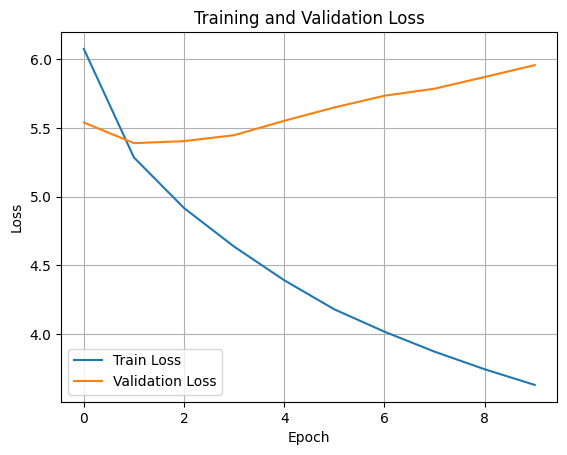

In [ ]:
model = TransformerLM(
    tgt_vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    dropout=dropout,
    max_seq_len=MAX_LEN
).to(DEVICE)

print(model)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer["[PAD]"], label_smoothing = 0.01)
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-3, weight_decay = 1e-4)

train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    tokenizer_inv=tokenizer_inv,
    tokenizer=tokenizer,
    device=DEVICE,
    num_epochs=10
)

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()

In [37]:
# ======================= Testing Code =======================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open("/kaggle/input/shakespear/shakespear_dev.txt", "r") as f:
    lines_test = f.readlines()

test_data = lines_test

test_dataset = ShakespeareDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32)

model = TransformerLM(
    tgt_vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff,
    dropout=dropout,
    max_seq_len=MAX_LEN
).to(DEVICE)

model.load_state_dict(torch.load("/kaggle/working/model_weights_2.pth"))

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer["[PAD]"], label_smoothing = 0.01)
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-3, weight_decay = 1e-4)

model.eval()
total_test_loss = 0
with torch.no_grad():
    for input_seq, target_seq in tqdm(test_loader, desc = "Testing"):
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)

        output = model(input_seq)
        loss = criterion(output.view(-1, output.size(-1)), target_seq.view(-1))
        total_test_loss += loss.item()

avg_test_loss = total_test_loss / len(val_loader)

print(f"\nTest perplexity: {math.exp(avg_test_loss)}")

<ipython-input-37-09f2412c2c8d>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/model_weights_2.pth"))
Testing: 100%|████


Test perplexity: 218.85939220712166


In [29]:
def inference(model_path, test_file, tokenizer, tokenizer_inv, gen_tokens=30, temperature=1.0, top_k=20, repetition_penalty=1.2):
    model = TransformerLM(
        tgt_vocab_size=vocab_size,
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_layers=num_layers,
        d_ff=d_ff,
        dropout=dropout,
        max_seq_len=MAX_LEN
    ).to(DEVICE)

    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer["[PAD]"], label_smoothing = 0.01)
    optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-3, weight_decay = 1e-4)
    
    with open(test_file, "r") as f:
        test_lines = [line.strip() for line in f if line.strip()]

    test_dataset = ShakespeareDataset(test_lines, tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    total_loss = 0
    total_tokens = 0
    generated_outputs = []

    with torch.no_grad():
        for input_seq, target_seq in tqdm(test_loader, desc = "Testing"):
            input_seq = input_seq.to(DEVICE)
            target_seq = target_seq.to(DEVICE)

            # Forward pass
            tgt_mask = model.generate_mask(input_seq)
            output = model(input_seq, tgt_mask=tgt_mask)

            # Compute loss
            loss = criterion(output.view(-1, output.size(-1)), target_seq.view(-1))
            total_loss += loss.item() * input_seq.numel()
            total_tokens += input_seq.numel()

            # Generate text from each input in the batch
            for inp in input_seq:
                sent = [x.item() for x in inp]
                sent = decode(sent, tokenizer_inv)
                sent = " ".join(sent)
                
                context = sent
                generated = generate_text(
                    model=model,
                    tokenizer=tokenizer,
                    tokenizer_inv=tokenizer_inv,
                    context=context,
                    gen_tokens=gen_tokens,
                    temperature=temperature,
                    top_k=top_k,
                    repetition_penalty=repetition_penalty
                )
                generated_outputs.append((context, generated))

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)

    print(f"Test Perplexity: {perplexity:.4f}\n")
    for context, gen in generated_outputs:
        print(f"Context: {context}\nGenerated: {gen}\n{'-'*50}")

    return generated_outputs, perplexity


model_path = "/kaggle/working/model_weights_2.pth"
test_file = "/kaggle/input/shakespear/shakespear_dev.txt"
generated_texts, ppl = inference(model_path, test_file, tokenizer, tokenizer_inv)

<ipython-input-29-b23768a647c1>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Testing: 100%|██████████| 41/41 [00:55<00:00,

Test Perplexity: 306.0835

Context: ﻿nay , if there be no remedy for it , but that you will needs buy and sell men and women like beasts , we shall have all the world drink brown and white bastard .
Generated: ﻿nay , if there be no remedy for it , but that you will needs buy and sell men and women like beasts , we shall have all the world drink brown and white bastard . '
 of a soldier , who , and , and so i ' which , to me with an heir of her man .
 .
 , that 's .
 .

--------------------------------------------------
Context: duke vincentio : o heavens !
Generated: duke vincentio : o heavens ! '
 of lancaster !
 !
 , and the king .
 .
 to hear me , and the king .
 , and all my heart .
 .
 and then ; we
--------------------------------------------------
Context: what stuff is here pompey : 't was never merry world since , of two usuries , the merriest was put down , and the worser allowed by order of law a furred gown to keep him warm ; and furred with fox and lamb-skins too , to sign

In [ ]:
print()

In [ ]:
# print(f"Test Perplexity: {ppl:.2f}")
# for prompt, text in generated_texts[:5]:
#     print(f"\nPrompt: {prompt}\nGenerated: {text}")